# Import Module and Data

In [47]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle
import os

import multiprocessing as mp
import numpy as np
import time
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

def processText(text,lemma=False, gram=1):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stopwordEn or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(tokens, gram)]

CPU numbers: 4


In [2]:
df = pd.read_csv('./Tweets.csv')
df.shape

(14640, 15)

# Explore Data

In [15]:
# show empty rate
(len(df)-df.count())/len(df)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [30]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Text(0.5, 1.0, 'Count of Sentiment')

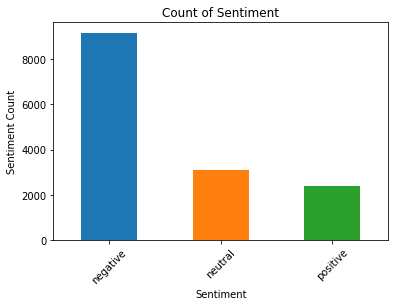

In [53]:
df.airline_sentiment.value_counts().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

In [28]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

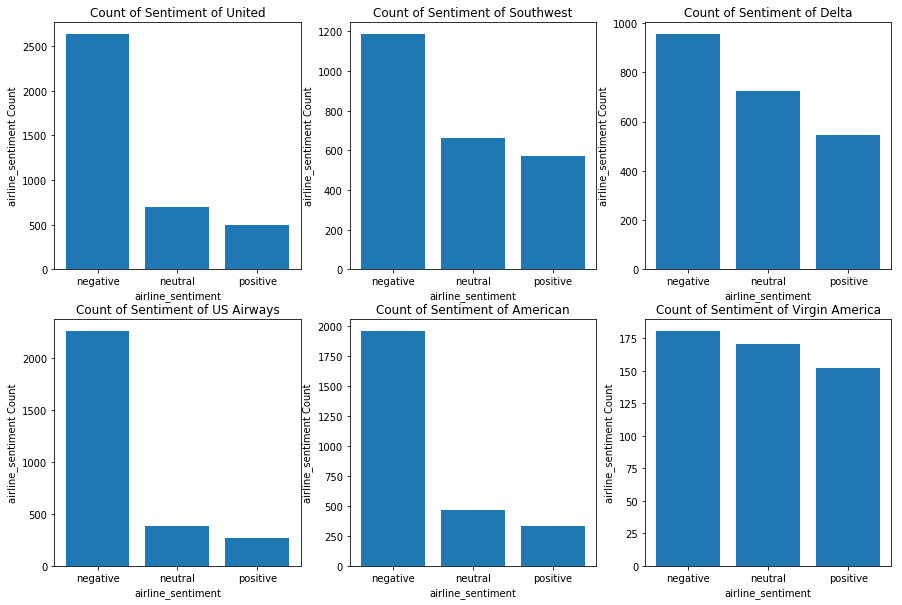

In [107]:
airlines = df['airline'].unique()
def plot_sub(Airline,attr='airline_sentiment',r=0):
    count = df[df['airline']==Airline][attr].value_counts()
    Index = count.keys()
    plt.bar(Index,count)
    plt.xticks(rotation=r)
    plt.ylabel('{} Count'.format(attr))
    plt.xlabel(attr)
    plt.title('Count of Sentiment of '+Airline)

def multi_subplot(attr='airline_sentiment',r=0,w=15,h=12):
    plt.figure(1,figsize=(w, h))
    for i in range(len(airlines)):
        plt.subplot(f'23{i}')
        plot_sub(airlines[i],attr,r)
        
multi_subplot(w=15,h=10)

In [65]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

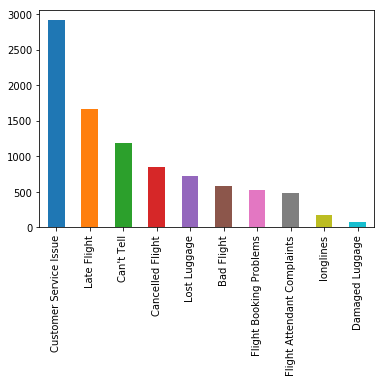

In [67]:
df.negativereason.value_counts().plot.bar()

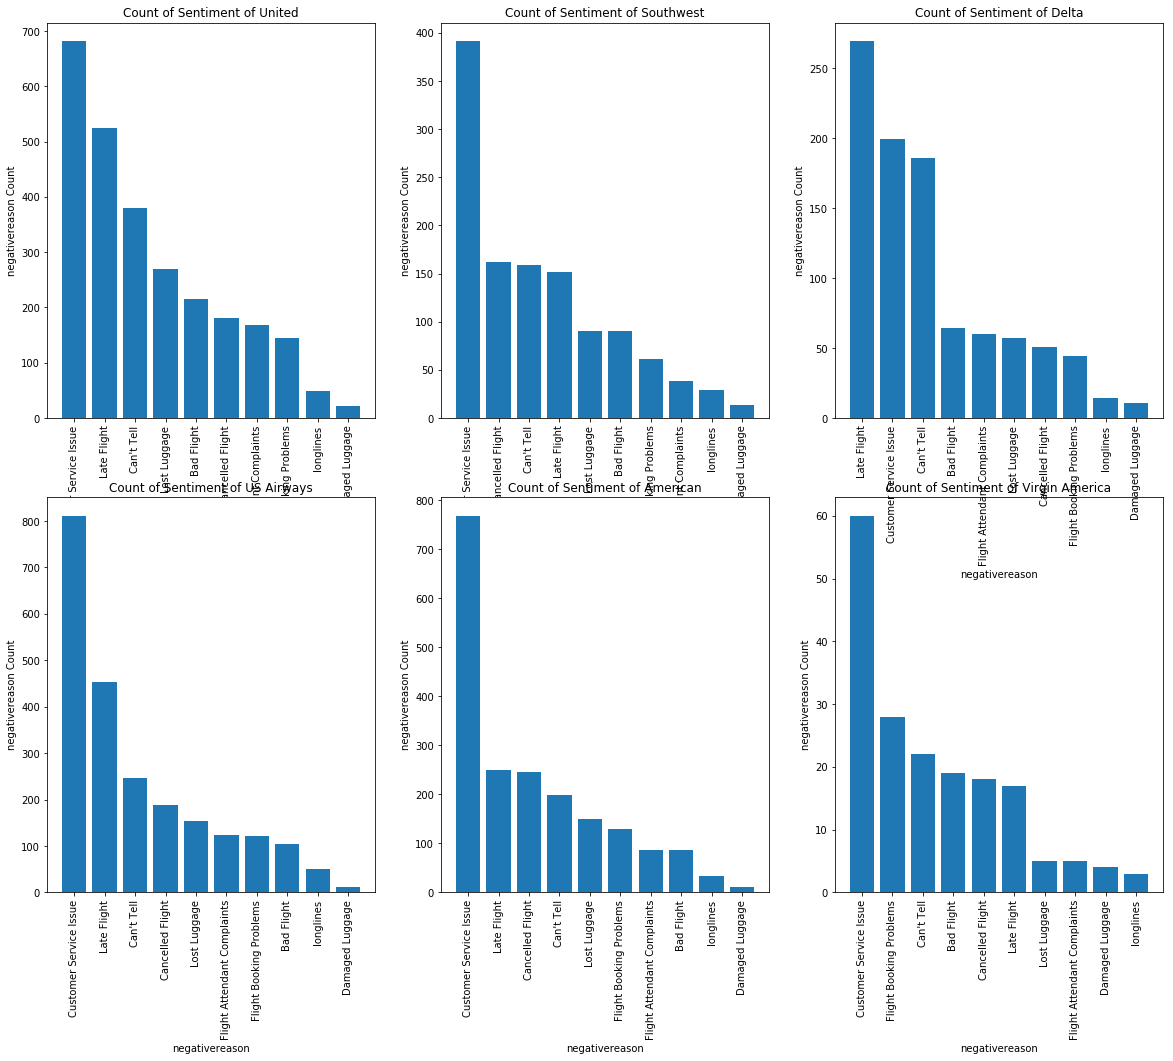

In [108]:
multi_subplot('negativereason',90,20,16)

In [38]:
df.retweet_count.value_counts().sort_index()

0     13873
1       640
2        66
3        22
4        17
5         5
6         3
7         3
8         1
9         1
11        1
15        1
18        1
22        2
28        1
31        1
32        1
44        1
Name: retweet_count, dtype: int64

# Prepare Data

In [8]:
df_sent = df.loc[:,['airline_sentiment','airline_sentiment_confidence','text']]
df_sent['text'] = [processText(i) for i in tqdm(df_sent['text'])]
# df_sent['text'] = apply_by_multiprocessing(df_sent['text'], processText, workers=4)

100%|██████████████████████████████████████████████████████████████████████████| 14640/14640 [00:09<00:00, 1566.62it/s]


In [44]:
dict_sent = {'negative':-1, 'neutral':0, 'positive':1}
df_sent['airline_sentiment'] = [dict_sent[i] for i in df_sent['airline_sentiment']]
df_sent.head()

,airline_sentiment,airline_sentiment_confidence,text
0,0,1.0000,[said]
1,1,0.3486,"[plus, added, commercials, experience, tacky]"
2,0,0.6837,"[today, must, mean, need, take, another, trip]"
3,-1,1.0000,"[really, aggressive, blast, obnoxious, enterta..."
4,-1,1.0000,"[really, big, bad, thing]"


In [45]:
with open('tweets_processed.pickle', 'wb') as handle:
    pickle.dump(df_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)